# Importing Important Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

!pip install -U tensorflow-addons

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


# Loading the BCD (Bird-Cat-Dog) Dataset

## The Training Set

In [2]:
img = np.zeros((3, 8, 8, 1), dtype = "uint8")

In [3]:
img[0][..., 0] = np.array([[158, 159,  49,  56,  60,  67,  47, 124],
                             [139, 144,  46,  40,  18,  50,  43, 148],
                             [152, 166, 167, 161, 158,  83, 110, 151],
                             [168, 169, 172, 166, 158,  68,  70, 151],
                             [163, 166,  52,  67, 149,  75,  54,  68],
                             [163, 166, 122, 174, 166,  83,  63, 184],
                             [158, 171,  84, 163, 171, 103,  52, 109],
                             [135, 155,  87,  22,  20, 113, 127, 150]],)
img[1][..., 0] = np.array([[115, 121, 118, 123, 116,  94, 107,  98],
                             [187, 121, 208, 161, 103,  67,  85,  86],
                             [ 78, 179,  83,  77,  73,  85,  92, 112],
                             [ 82,  78,  62,  79,  93,  81, 122,  70],
                             [ 86, 122, 122,  95,  74, 113,  74, 105],
                             [172, 103, 108, 107, 116, 104,  64, 119],
                             [125, 120, 208, 126,  63, 139,  89,  48],
                             [131, 113, 123, 174,  89, 129,  84,  89]])
img[2][..., 0] = np.array([[ 85, 103, 146, 113,  83,  71,  34,  38],
                             [ 34,  72,  66,  70,  69,  46,  35,  21],
                             [ 78, 115,  61,  26,  38,  33,  49,  43],
                             [112,  63, 194, 121, 178, 184, 187, 106],
                             [ 78,  80, 148, 101,  73, 127, 144, 150],
                             [113,  80,  98,  86, 108,  72,  41,  47],
                             [132,  97, 145, 130, 181, 178, 179, 139],
                             [103, 104, 147, 117, 113,  30,  34,  38]])

In [4]:
y = np.array([0, 1, 2], dtype = "uint8")

# Creating Labels to Show with Output

In [5]:
labels = [ 'Bird', 'Cat', 'Dog']

# The 3 Training Matrices


Printing Bird: 
[[158 159  49  56  60  67  47 124]
 [139 144  46  40  18  50  43 148]
 [152 166 167 161 158  83 110 151]
 [168 169 172 166 158  68  70 151]
 [163 166  52  67 149  75  54  68]
 [163 166 122 174 166  83  63 184]
 [158 171  84 163 171 103  52 109]
 [135 155  87  22  20 113 127 150]]

Printing Cat: 
[[115 121 118 123 116  94 107  98]
 [187 121 208 161 103  67  85  86]
 [ 78 179  83  77  73  85  92 112]
 [ 82  78  62  79  93  81 122  70]
 [ 86 122 122  95  74 113  74 105]
 [172 103 108 107 116 104  64 119]
 [125 120 208 126  63 139  89  48]
 [131 113 123 174  89 129  84  89]]

Printing Dog: 
[[ 85 103 146 113  83  71  34  38]
 [ 34  72  66  70  69  46  35  21]
 [ 78 115  61  26  38  33  49  43]
 [112  63 194 121 178 184 187 106]
 [ 78  80 148 101  73 127 144 150]
 [113  80  98  86 108  72  41  47]
 [132  97 145 130 181 178 179 139]
 [103 104 147 117 113  30  34  38]]


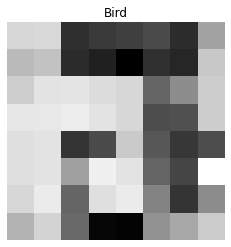

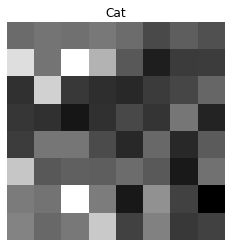

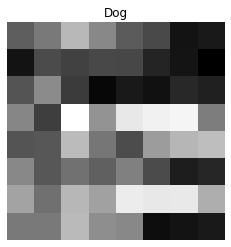

In [ ]:
for i in y:
    plt.figure(figsize=(4, 4))
    image = img[i][..., 0]
    plt.title(labels[i])
    plt.imshow(image, cmap='gray')
    plt.axis("off")
    print(f'\nPrinting {labels[i]}: \n{image}')

# Initializing Hyperparameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 8
patch_size = 4
num_patches = (image_size // patch_size) ** 2
projection_dim = 16#64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 4#8
mlp_head_units = [2048, 1024]

# Patch Maker

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
    
    #@tf.function
    def call(self, images):
        batch_size = tf.shape(images)[0]#/3
        #print(type(images))
        #print(type(tf.shape(images)))
        #print(type(batch_size))
        #tf.print("batch_size:", batch_size)
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        #print("patch_size:", patch_size)
        patch_dims = patches.shape[-1]
        #print("Pikachu! patch dims", patch_dims)
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        #print(patches.shape)
        #if patches.shape[0] != None:
            #plt.figure(figsize=(4, 4))
            #print(len(patches))
            
            #for c in range(len(patches)):
                #n = 2 #int(np.sqrt(patches[c].shape[1]))
                #for i, patch in enumerate(patches[c]):
                    #ax = plt.subplot(n, n, i+1)
                    #patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
                    #plt.imshow(patch_img.numpy().astype("uint8"))
                    #plt.axis("off")
                    #print(f'\nPatch {i+1}:\n{patch_img[..., 0].numpy()}')
        tf.print("\nThe patches:\n\nOriginal Form\n", patches, summarize = -1)
        for i in range(len(patches)):
          tf.print("\nImage", i+1)
          for j in range(len(patches[0])):
            tf.print("Patch", j+1)
            tf.print(patches[i, j], summarize = -1)
        #tf.print("Patches:", patches[..., 0:49:3])
        #print(patches.shape)
        
        #print('Inside faltu Patches.call() function')
        return patches

## Patch Testing

In [ ]:
patches = Patches(patch_size)(img)
#print(patches.shape)
n = int(np.sqrt(patches.shape[1]))


The patches:

Original Form
 [[[158 159 49 56 139 144 46 40 152 166 167 161 168 169 172 166]
  [60 67 47 124 18 50 43 148 158 83 110 151 158 68 70 151]
  [163 166 52 67 163 166 122 174 158 171 84 163 135 155 87 22]
  [149 75 54 68 166 83 63 184 171 103 52 109 20 113 127 150]]

 [[115 121 118 123 187 121 208 161 78 179 83 77 82 78 62 79]
  [116 94 107 98 103 67 85 86 73 85 92 112 93 81 122 70]
  [86 122 122 95 172 103 108 107 125 120 208 126 131 113 123 174]
  [74 113 74 105 116 104 64 119 63 139 89 48 89 129 84 89]]

 [[85 103 146 113 34 72 66 70 78 115 61 26 112 63 194 121]
  [83 71 34 38 69 46 35 21 38 33 49 43 178 184 187 106]
  [78 80 148 101 113 80 98 86 132 97 145 130 103 104 147 117]
  [73 127 144 150 108 72 41 47 181 178 179 139 113 30 34 38]]]

Image 1
Patch 1
[158 159 49 56 139 144 46 40 152 166 167 161 168 169 172 166]
Patch 2
[60 67 47 124 18 50 43 148 158 83 110 151 158 68 70 151]
Patch 3
[163 166 52 67 163 166 122 174 158 171 84 163 135 155 87 22]
Patch 4
[149 75 54 68 1


Patch 1:
[158 139 152 168]

Patch 2:
[ 60  18 158 158]

Patch 3:
[163 163 158 135]

Patch 4:
[149 166 171  20]


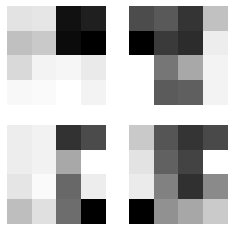

In [ ]:
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size))
    plt.imshow(patch_img.numpy().astype("uint8"), cmap="gray")
    plt.axis("off")
    print(f'\nPatch {i+1}:\n{patch_img[..., 0].numpy()}')


Patch 1:
[115 187  78  82]

Patch 2:
[116 103  73  93]

Patch 3:
[ 86 172 125 131]

Patch 4:
[ 74 116  63  89]


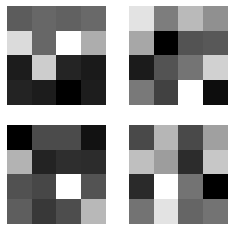

In [ ]:
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[1]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size))
    plt.imshow(patch_img.numpy().astype("uint8"), cmap="gray")
    plt.axis("off")
    print(f'\nPatch {i+1}:\n{patch_img[..., 0].numpy()}')


Patch 1:
[ 85  34  78 112]

Patch 2:
[ 83  69  38 178]

Patch 3:
[ 78 113 132 103]

Patch 4:
[ 73 108 181 113]


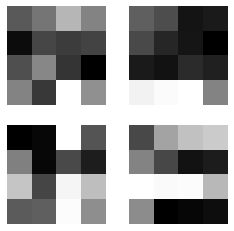

In [ ]:
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[2]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size))
    plt.imshow(patch_img.numpy().astype("uint8"), cmap="gray")
    plt.axis("off")
    print(f'\nPatch {i+1}:\n{patch_img[..., 0].numpy()}')

# Patch Encoder

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
 
    def call(self, patch):
        #print('Inside PatchEncoder.call() function')
        #tf.print("patch:\n", patch[..., 0:49:3], summarize = -1)
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        #print("\n1st Dense Layer Type:", type(self.projection))
        tf.print("\nPatch Positions:", positions, "\n")

        projection = self.projection(patch)
        position_embedding = self.position_embedding(positions)
        encoded = projection + position_embedding

        tf.print("Config of Dense Layer:\n",self.projection.get_config())
        tf.print("\nWeights of Dense Layer:\n",self.projection.kernel#get_weights()
        , summarize = -1)
        tf.print("\nBiases of Dense Layer:\n",self.projection.bias#get_weights()
        , summarize = -1)
        tf.print("\nConfig of Embedded Layer:\n",self.position_embedding.get_config())
        tf.print("\nShape of patch: ",patch.shape)
        tf.print("\nWeights of Embedding Layer:\n",self.position_embedding.weights#get_weights()
        , summarize = -1)
        #print(patch.shape)
        #print(patch[..., 0])
        #plt.figure(figsize=(4, 4))
        #patch_img = tf.reshape(patch[0][0], (patch_size, patch_size, 3))
        #print(type(patch_img))
        #print(type(np.ndarray(patch_img)))
        #plt.imshow(np.squeeze(np.ndarray((None, None, 192))))#.numpy().astype('uint8'))
        #plt.show()
        #plt.axis('off')
        #print(type(encoded))
        tf.print("\nAfter Applying projection (layers.Dense) on patches:\n------\n", projection, summarize = -1)
        tf.print("\nProjection Shape: ",projection.shape)
        
        tf.print("\n\nAfter Applying position_embedding (layers.Embedding) on the patch positions:\n------\n", position_embedding, summarize = -1)
        tf.print("\nPosition Encoding Shape: ",position_embedding.shape)
        
        tf.print("\n\nEncoded Patches got After Adding Positional Encoding with Projected Patches:\n------\n", encoded, "\n", summarize = -1)

        return encoded

In [ ]:
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)


Patch Positions: [0 1 2 3] 

Config of Dense Layer:
 {'activation': 'linear',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'dtype': 'float32',
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'GlorotUniform',
                        'config': {'seed': None}},
 'kernel_regularizer': None,
 'name': 'dense_2',
 'trainable': True,
 'units': 16,
 'use_bias': True}

Weights of Dense Layer:
 [[0.107159585 0.0783665478 -0.267110229 0.0820816457 0.411310762 -0.308055758 -0.0299633741 0.28102687 0.141943961 0.291959792 -0.401023895 0.199015826 -0.120983601 -0.0604581833 -0.394967228 -0.0520730615]
 [-0.231052414 -0.04369241 0.281621724 -0.207777247 -0.0553296208 -0.222598642 0.167679101 -0.147372544 -0.153863728 -0.348562241 -0.158427805 -0.193333283 -0.0144833922 0.378675908 -0.0772389472 -0.255580693]
 [0.0836195648 0.164533526 0.26475516 -0.409141928 0.27500537 0.156873852 0.2

# Building MLP Network

In [ ]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation = tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

# Building Vision Transformer

In [ ]:
def create_vit_classifier():
    #print('Inside create_vit_classifier() function')
    inputs = layers.Input(shape=img[0].shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
 
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])
 
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    #tf.print("\nAfter Applying LayerNormalization on encoded_patches:", representation, summarize = -1)
    representation = layers.Flatten()(representation)
    #tf.print("\nAfter Applying Flatten on representation:", representation, summarize = -1)
    representation = layers.Dropout(0.5)(representation)
    #tf.print("\nAfter Applying Dropout on representation:", representation, summarize = -1)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    #tf.print("\nfeatures:", features, summarize = -1)
    logits = layers.Dense(3)(features)
    #tf.print("\nlogits:", logits, summarize = -1)                 
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# Compiling and Training

## Compilation

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

model = create_vit_classifier()

model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
       keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
       keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"), ],)

## Plot of the Model

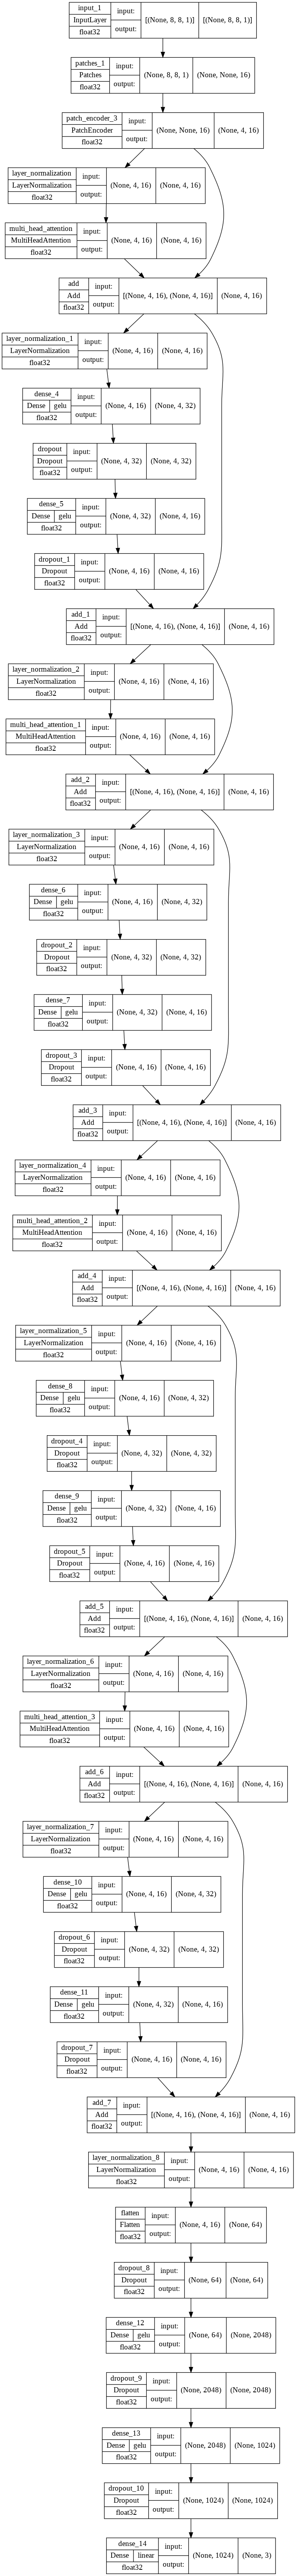

In [ ]:
plot_model(model, to_file = "TheTransformer.png", show_shapes = True, show_layer_names = True, show_dtype = True, show_layer_activations = True)

## Training

In [ ]:
model.fit(x=img, y=y, batch_size=batch_size, epochs=5)

Epoch 1/5

The patches:

Original Form
 [[[158 159 49 56 139 144 46 40 152 166 167 161 168 169 172 166]
  [60 67 47 124 18 50 43 148 158 83 110 151 158 68 70 151]
  [163 166 52 67 163 166 122 174 158 171 84 163 135 155 87 22]
  [149 75 54 68 166 83 63 184 171 103 52 109 20 113 127 150]]

 [[115 121 118 123 187 121 208 161 78 179 83 77 82 78 62 79]
  [116 94 107 98 103 67 85 86 73 85 92 112 93 81 122 70]
  [86 122 122 95 172 103 108 107 125 120 208 126 131 113 123 174]
  [74 113 74 105 116 104 64 119 63 139 89 48 89 129 84 89]]

 [[85 103 146 113 34 72 66 70 78 115 61 26 112 63 194 121]
  [83 71 34 38 69 46 35 21 38 33 49 43 178 184 187 106]
  [78 80 148 101 113 80 98 86 132 97 145 130 103 104 147 117]
  [73 127 144 150 108 72 41 47 181 178 179 139 113 30 34 38]]]

Image 1
Patch 1
[158 159 49 56 139 144 46 40 152 166 167 161 168 169 172 166]
Patch 2
[60 67 47 124 18 50 43 148 158 83 110 151 158 68 70 151]
Patch 3
[163 166 52 67 163 166 122 174 158 171 84 163 135 155 87 22]
Patch 4
[149 